In [37]:
import numpy as np
import pandas as pd
import scipy
import random
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

## Single-digit neural single layer network trained on the MNIST dataset

I implemented a neural single layer network with symmetric architecture trained on the MNIST dataset that performs single digit architecture and tried to study the asymptotic distribution of network parameters as claimed in the 2019 paper by Sirgiano and Spiliopoulos entitled 'Mean Field Analysis of Neural Networks: A Law of Large Numbers'.

In [6]:
def sigmoid(x):
    if x < 0:
        return np.exp(x)/(1+np.exp(x))
    else:
        return 1/(1+np.exp(-x))
vsigmoid = np.vectorize(sigmoid)   

In [7]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [8]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data[data.columns[0]]))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data[test_data.columns[0]])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)


x_train = train_data_std
y_train = np.where(y_train == 0,  1, -1)
x_test = test_data_std
y_test = np.where(y_test == 0,  1, -1)

In [9]:
def neural_net(x,w,c):
    """
    Compute the output of a neural network with given weights and coefficients.

    Parameters:
    x (np.ndarray): Input data with shape (n, d).
    w (np.ndarray): Weight matrix with shape (N, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, N).

    Returns:
    np.ndarray: The output of the neural network with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    N = w.shape[0]
    return (1/N*c@vsigmoid(w@x.T)).reshape(1,n)

In [75]:
def train(x_train, y_train, x_test, y_test, N = 100, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using stochastic gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    learning_rate (float): The learning rate for stochastic gradient descent (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #sgd - update weights (using KL loss)
    epoch = 1
    
    while epoch < 1e6:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
    
        for x,y in tqdm(np.random.shuffle(zip(x_train,y_train))):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w,c).reshape(1,-1)
            s = vsigmoid(w@x.T)
            dw = 1/N * ((f-y)@c).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w -= learning_rate*dw
            c -= learning_rate*dc

            if  epoch in [1, 10 , 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            epoch += 1 
        
    return c, w, np.ndarray.flatten(c), losses

In [76]:
def nesterov_train(x_train, y_train, x_test, y_test, N = 100, r = 3, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using Nesterov's accelerated gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    learning_rate (float): The learning rate for Nesterov's SGD (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    epoch = 1
    while epoch < 1e6:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
    
        for x,y in tqdm(zip(x_train,y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w_change,c_change).reshape(1,-1)
            s = vsigmoid(w_change@x.T)
            dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w1 = w
            c1 = c

            if  epoch in [1, 10 , 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            w_new = w_change - learning_rate*dw
            c_new = c_change - learning_rate*dc
            w_change = w_new + 0.9*(w_new-w1) 
            c_change = c_new + 0.9*(c_new-c1) 
            w = w_new
            c = c_new

            epoch += 1
        
    return c, w, np.ndarray.flatten(c), losses

In [78]:
def Hom_SGLD(x_train, y_train, x_test, y_test, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):
    """
    Train a neural network with a specified number of units (N) using Hamiltonian SGLD (Hom-SGLD).

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    M (int): The number of Hamiltonian SGLD steps (default is 20).
    λ (float): The regularization parameter (default is 10).
    learning_rate (float): The learning rate for Hom-SGLD (default is 1e-3).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and an array of loss values during training.
    """

    #initialise Params
    d = x_train.shape[1]
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((M+1, N, d))
    Y_c = np.zeros((M+1, N))
    
    losses = []
    
    epoch = 1
    while epoch < 1e6:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
    
        for x,y in tqdm(zip(x_train,y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)

            #update Y
            Y_w_1 = np.zeros((M+1, N, d))
            Y_c_1 = np.zeros((M+1, N))
            Y_w_1[0, :, :] = Y_w[-1, :, :] 
            Y_c_1[0, :] = Y_c[-1, :]

            for m in range(1,M+1):
                δ = 0.01/20
                γ = 0.1
                β = 10
                f = neural_net(x, Y_w_1[m-1, :, :].reshape((N,d)),  Y_c_1[m-1, :].reshape((1,N)))
                s = vsigmoid(Y_w_1[m-1, :, :].reshape((N,d))@x.T)
                dw = 1/N * ((f-y)@Y_c_1[m-1,:].reshape(1,N)).T*(s*(1-s))*x
                dc = 1/N * (f-y).T*s.reshape(1,-1)

                Y_w_1[m, :,:] = Y_w_1[m-1, : ,:] - δ*(dw-(1/γ)*(w-Y_w_1[m-1, :, :]))\
                + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
                Y_c_1[m, :] = Y_c_1[m-1,:] - δ*(dc-(1/γ)*(c-Y_c_1[m-1, :]))\
                + np.sqrt(2*(δ/β))*np.random.normal(0,1,N)

            Y_w[0, :, :] = Y_w_1[-1, :, :]
            Y_c[0, :] = Y_c_1[-1, :]


            cal_Y_w = np.mean(Y_w_1, axis = 0)
            cal_Y_c = np.mean(Y_c_1, axis = 0)


            #update model parameters
            Δ = learning_rate
            X = np.hstack((w, c.T))
            mu = np.mean(X, axis = 1).reshape(1,N)
            w = w - 1/γ*(w-cal_Y_w)*Δ - λ*(w - mu.T)*Δ
            c = c - 1/γ*(c-cal_Y_c)*Δ - λ*(c - mu)*Δ

            if  epoch in [1, 10, 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            epoch +=1
                
    return c, w, np.ndarray.flatten(c), np.array(losses)

In [74]:
def Mass(x_train, y_train, x_test, y_test, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):
    """
    Train a neural network with a specified number of units (N) using Momentum-added Stochastic Solver (Mass).

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    M (int): The number of Mass steps (default is 20).
    λ (float): The regularization parameter (default is 10).
    learning_rate (float): The learning rate for Mass (default is 1e-3).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w',
           and an array of loss values during training.
    """

    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    epoch = 1
    
    while epoch < 1e6:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
        
        for x,y in tqdm(zip(x_train, y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w_change,c_change).reshape(1,-1)
            s = vsigmoid(w_change@x.T)
            dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w1 = w
            c1 = c

            alpha = 0.05
            m = 2
            eta2 = learning_rate/(1+alpha)/m

            w_new = w_change - learning_rate*dw
            c_new = c_change - learning_rate*dc
            w_change = w_new + 0.9*(w_new-w1) - eta2*dw
            c_change = c_new + 0.9*(c_new-c1) - eta2*dc
            w = w_new
            c = c_new

            if  epoch in [1, 10, 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            epoch +=1
                
    return c, w, np.array(losses)

In [72]:
c, w, risk_Mass = Mass(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 15393.918997799234
Epoch count: 10, Loss: 34189.27516392988
Epoch count: 100, Loss: 23559.038847285094
Epoch count: 1000, Loss: 10725.155134835726
Epoch count: 1268, Loss: 9467.697975591984
Epoch count: 1610, Loss: 7516.677572776756
Epoch count: 2043, Loss: 5235.904168982715
Epoch count: 2592, Loss: 3755.31010983898
Epoch count: 3290, Loss: 2506.045119180846
Epoch count: 4175, Loss: 1969.1101706792756
Epoch count: 5298, Loss: 1787.4434498147268
Epoch count: 6723, Loss: 1451.6676474844892
Epoch count: 8531, Loss: 1275.0932874704001
Epoch count: 10826, Loss: 1130.7814069508909
Epoch count: 13738, Loss: 889.9684271478186
Epoch count: 17433, Loss: 800.6963137482736
Epoch count: 22122, Loss: 593.0118779579884
Epoch count: 28072, Loss: 523.4071709545527
Epoch count: 35622, Loss: 417.1880155038544
Epoch count: 45203, Loss: 331.8375325312169
Epoch count: 57361, Loss: 242.3329181613068


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 166.6559932173077
Epoch count: 92367, Loss: 108.46958300748591
Epoch count: 117210, Loss: 65.59033385569501


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 35.14305814168125


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 16.420115521257145
Epoch count: 239502, Loss: 6.5377734361544295


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 2.1796817706274103


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 0.6357569968169013


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 0.2417936451407197


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 0.17229076262324738


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 0.1644064721721076


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 0.16377657208136312


In [79]:
#simulate HomSGLD

c_HomSGLD, weights_HomSGLD, params_HomSGLD, risk_HomSGLD,  =\
Hom_SGLD(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 4081.5504312464664
Epoch count: 10, Loss: 10719.726728323581
Epoch count: 100, Loss: 562.7721473497878
Epoch count: 1000, Loss: 0.5000142720900663
Epoch count: 1268, Loss: 0.49985810371457357
Epoch count: 1610, Loss: 0.500114681245795
Epoch count: 2043, Loss: 0.5000642804139379
Epoch count: 2592, Loss: 0.5002252084245307
Epoch count: 3290, Loss: 0.4999679972269551
Epoch count: 4175, Loss: 0.5000146765813093
Epoch count: 5298, Loss: 0.5001032623703033
Epoch count: 6723, Loss: 0.4998239310027438
Epoch count: 8531, Loss: 0.4997566359087432
Epoch count: 10826, Loss: 0.49978800346061536
Epoch count: 13738, Loss: 0.4999561282126192
Epoch count: 17433, Loss: 0.4998905768115754
Epoch count: 22122, Loss: 0.49985242883438136
Epoch count: 28072, Loss: 0.49985615628090013
Epoch count: 35622, Loss: 0.5000563740396933
Epoch count: 45203, Loss: 0.5000011153380478
Epoch count: 57361, Loss: 0.49989761109207115


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 0.5000492973980549
Epoch count: 92367, Loss: 0.5000935248440254
Epoch count: 117210, Loss: 0.500119760988668


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 0.4999710307816791


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 0.49977697751501826
Epoch count: 239502, Loss: 0.5000703978591167


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 0.5000265269478978


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 0.4995659227687845


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 0.5001198485812275


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 0.4997451197037519


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 0.4997394156080373


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 0.49994921347415633


In [23]:
c, w, params, risk_SGD = train(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 8757.830456349577
Epoch count: 10, Loss: 6684.139453891309
Epoch count: 100, Loss: 4275.5656906485165
Epoch count: 1000, Loss: 3020.7351299410598
Epoch count: 1268, Loss: 3087.0500610996323
Epoch count: 1610, Loss: 2940.3436257980147
Epoch count: 2043, Loss: 2593.365086859118
Epoch count: 2592, Loss: 2589.0802821055067
Epoch count: 3290, Loss: 2249.9565578959796
Epoch count: 4175, Loss: 2055.075911148001
Epoch count: 5298, Loss: 1984.8187388315675
Epoch count: 6723, Loss: 1802.5502279812983
Epoch count: 8531, Loss: 1663.5393184691943
Epoch count: 10826, Loss: 1599.0316373260252
Epoch count: 13738, Loss: 1466.9462792653335
Epoch count: 17433, Loss: 1297.4700299724118
Epoch count: 22122, Loss: 1230.8885163492216
Epoch count: 28072, Loss: 1129.7723489835025
Epoch count: 35622, Loss: 980.2466536729983
Epoch count: 45203, Loss: 911.1003615256889
Epoch count: 57361, Loss: 808.8397873273291


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 755.0597408111511
Epoch count: 92367, Loss: 677.8522506544914
Epoch count: 117210, Loss: 538.7486875070036


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 478.5430350372171


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 441.34227515537486
Epoch count: 239502, Loss: 373.83903187463176


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 305.8216600898673


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 255.89082135179123


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 226.39982095834856


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 183.82949715045487


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 184.2075613015136


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 136.3719552424685


In [77]:
c, w, params_NSGD, risk_NSGD = nesterov_train(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 4067.665608899683
Epoch count: 10, Loss: 14039.975361923556
Epoch count: 100, Loss: 7094.894713130203
Epoch count: 1000, Loss: 2866.738682548947
Epoch count: 1268, Loss: 3216.8462179042203
Epoch count: 1610, Loss: 2568.74003239309
Epoch count: 2043, Loss: 2125.552022320733
Epoch count: 2592, Loss: 2159.1898565613355
Epoch count: 3290, Loss: 1799.4017157882306
Epoch count: 4175, Loss: 1837.4156805468608
Epoch count: 5298, Loss: 1892.179113046577
Epoch count: 6723, Loss: 1744.8206626232286
Epoch count: 8531, Loss: 1589.628171159422
Epoch count: 10826, Loss: 1419.398810894159
Epoch count: 13738, Loss: 1382.26507922387
Epoch count: 17433, Loss: 1214.563959542325
Epoch count: 22122, Loss: 1046.9781339139174
Epoch count: 28072, Loss: 838.2085753065879
Epoch count: 35622, Loss: 747.6819015865433
Epoch count: 45203, Loss: 617.794253179534
Epoch count: 57361, Loss: 480.5079737100415


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 362.80680302676024
Epoch count: 92367, Loss: 256.07734100473476
Epoch count: 117210, Loss: 168.8695015946189


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 106.17390160780447


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 59.79858018600232
Epoch count: 239502, Loss: 29.28650680349684


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 12.271411946854716


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 4.243757626890949


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 1.1860217910615785


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 0.32677316141324303


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 0.1627105814619987


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 0.1439466201783618


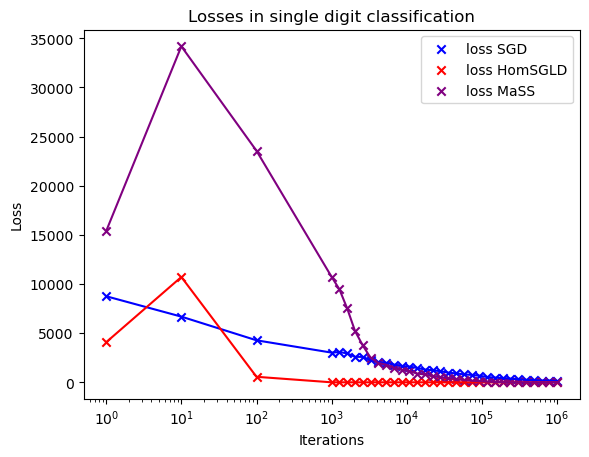

In [80]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1, 10 , 100] + list((10**np.linspace(3, 6, 30)).astype(int))
#indices = [1, 10 , 100] + list((10**np.linspace(3, 4.5, 20)).astype(int))
indices_hom = [1, 10, 50, 100, 200, 300, 500, 700, 900] + list((10**np.linspace(3, 4.7, 20)).astype(int))
fig, ax = plt.subplots()
ax.plot(indices_SGD, risk_SGD, c = 'b')
#ax.plot(indices, risk_NSGD, c = 'g')
#ax.plot(indices, risk_HomSGLD, c = 'r')
ax.plot(indices, risk_Mass, c = 'purple')
ax.scatter(indices_SGD, risk_SGD, marker = 'x', c = 'b', label = 'loss SGD')
#ax.scatter(indices, risk_NSGD, marker = 'x', c = 'g', label = 'loss NSGD')
#ax.scatter(indices, risk_HomSGLD, marker = 'x', c = 'r', label = 'loss HomSGLD')
ax.scatter(indices, risk_Mass, marker = 'x', c = 'purple', label = 'loss MaSS')


ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Losses in single digit classification')
ax.legend()
plt.show()

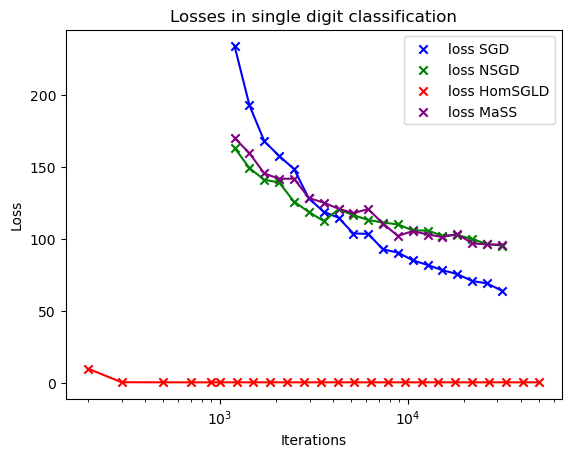

In [213]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1, 10 , 100] + list((10**np.linspace(3, 4.5, 20)).astype(int))
indices_hom = [1, 10, 50, 100, 200, 300, 500, 700, 900] + list((10**np.linspace(3, 4.7, 20)).astype(int))
fig, ax = plt.subplots()
ax.plot(indices[4:], risk_SGD[4:], c = 'b')
ax.plot(indices[4:], risk_NSGD[4:], c = 'g')
ax.plot(indices_hom[4:], risk_HomSGLD[4:], c = 'r')
ax.plot(indices[4:], risk_Mass[4:], c = 'purple')
ax.scatter(indices[4:], risk_SGD[4:], marker = 'x', c = 'b', label = 'loss SGD')
ax.scatter(indices[4:], risk_NSGD[4:], marker = 'x', c = 'g', label = 'loss NSGD')
ax.scatter(indices_hom[4:], risk_HomSGLD[4:], marker = 'x', c = 'r', label = 'loss HomSGLD')
ax.scatter(indices[4:], risk_Mass[4:], marker = 'x', c = 'purple', label = 'loss MaSS')


ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Losses in single digit classification')
ax.legend()
plt.show()

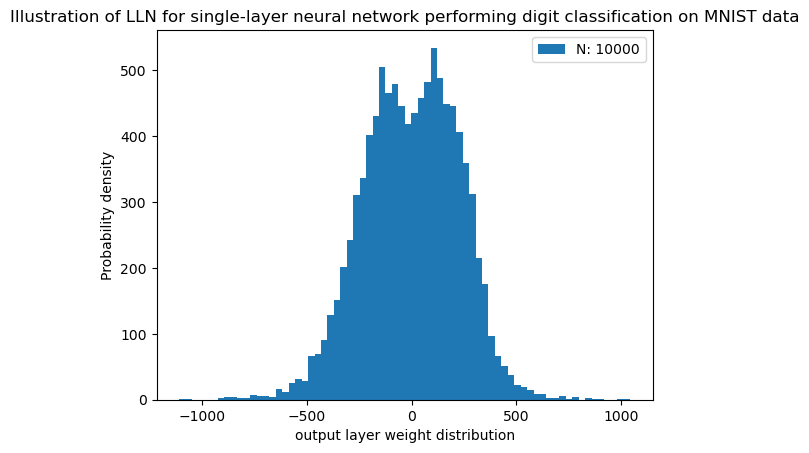

In [43]:
plt.hist(params, label = 'N: 10000', bins = 70)
plt.title('Illustration of LLN for single-layer neural network performing digit classification on MNIST data')
plt.ylabel('Probability density')
plt.xlabel('output layer weight distribution')
plt.legend()

## General Observations

- Nesterov acceleration beat plain SGD, but was beaten by MF-HomSGLD, which plateaued early but achieved a substantially smaller loss in the same amount of time
- MF-HomSGLD (in the paper by Pavliotis, Kantas and Parpas entitled 'The sharp, the flat and the shallow: Can weakly interacting agents learn to escape bad minima?') matches the performance of plain SGD. Still, it gets stuck for more significant iterations and plateaus. However, in the MNIST one-digit classification, the algorithm attains a substantially smaller loss, about two orders of magnitude less than the other algorithms. However, it suffers from plateauing early again.
- Finally, the single-digit classifier with the architecture satisfied the assumptions made in the paper. It was able to reproduce the distribution of parameters in the paper, as seen in the plot above, capturing the bimodality of the network parameter distribution in the paper.